In [3]:

# setup
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets import cifar10
from keras import models
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.layers.core import Activation
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [4]:
# load 
def load_crime_data(df):                                                    # Create a function load_crime_data() 
    dt = pd.read_csv(df,delim_whitespace = False,header=None)               # Read the csv file using “pandas.read_csv”.and then replace “?” with “np.NAN” 
    dt = dt.replace("?",np.NAN)
    dt = dt.values                                                          # Then we extract the values from the dataframe using dataframe.values• 
    train_data = dt[:1500,5:127].astype("float")
    test_data = dt[1500:,5:127].astype("float")
    train_labels = dt[:1500,127:128].astype("float")
    test_labels = dt[1500:,127:128].astype("float")
    return (train_data,train_labels),(test_data,test_labels)
    

In [5]:
(train_data,train_labels),(test_data,test_labels) = load_crime_data("https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data")

In [6]:
imp = SimpleImputer(missing_values=np.NAN, strategy='mean')
train_data = imp.fit_transform(train_data)
test_data = imp.fit_transform(test_data)
train_labels = imp.fit_transform(train_labels)
test_labels = imp.fit_transform(test_labels)
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(1500, 122)
(494, 122)
(1500, 1)
(494, 1)


In [7]:
train_data

array([[0.19      , 0.33      , 0.02      , ..., 0.5       , 0.32      ,
        0.14      ],
       [0.        , 0.16      , 0.12      , ..., 0.45188285, 0.        ,
        0.19075314],
       [0.        , 0.42      , 0.49      , ..., 0.45188285, 0.        ,
        0.19075314],
       ...,
       [0.        , 0.52      , 0.04      , ..., 0.45188285, 0.        ,
        0.19075314],
       [0.04      , 0.51      , 0.07      , ..., 0.45188285, 0.        ,
        0.19075314],
       [0.03      , 0.59      , 0.2       , ..., 0.45188285, 0.        ,
        0.19075314]])

In [8]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])                           #compile the model using the optimizer RMSprop
    return model

In [9]:
# Training and validation of the model 

k = 4
num_val_sample = len(train_data)//k
num_epochs = 300
all_scores = []
all_mae_histories = []

# k-fold cross validation
for i in range(k):
    print('processing fold #',i)
    
    # prepare validation fold
    val_data = train_data[i * num_val_sample: (i+1) * num_val_sample]
    val_labels = train_labels[i * num_val_sample: (i+1) * num_val_sample]
    
    # concentrate training fold
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_sample],
         train_data[(i+1) * num_val_sample:]],
        axis = 0)
    partial_train_labels = np.concatenate(
        [train_labels[:i*num_val_sample],
         train_labels[(i+1)*num_val_sample:]],
        axis=0)
   
    # train using the training fold
    model = build_model() # create a compiled model using our function
    history = model.fit(
    partial_train_data,partial_train_labels,
    epochs=num_epochs,batch_size=32,verbose=0) # silent mode (verbose=0)
    test_mse_score,test_mae_score = model.evaluate(val_data,val_labels)
    print(test_mae_score)

    # training performance
    history_dict = history.history
    mae_history = history.history['mae']
    all_mae_histories.append(mae_history)
    
    # validation set performace per fold
    val_mse,val_mae = model.evaluate(val_data,val_labels,verbose=0)
    all_scores.append(val_mae)
    

# find average per-epoch MAE score for all folds
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

processing fold # 0
12/12 [==============================] - 0s 2ms/step - loss: 0.0250 - mae: 0.1152
0.1152406856417656
processing fold # 1
12/12 [==============================] - 0s 2ms/step - loss: 0.0368 - mae: 0.1256
0.12564711272716522
processing fold # 2
12/12 [==============================] - 0s 3ms/step - loss: 0.0225 - mae: 0.1041
0.10413530468940735
processing fold # 3
12/12 [==============================] - 0s 2ms/step - loss: 0.0194 - mae: 0.0963
0.09634475409984589


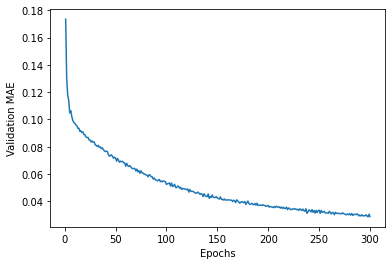

In [10]:
#  Plot the results on the graph
import matplotlib.pyplot as plt
plt.plot(range(1,len(average_mae_history)+1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

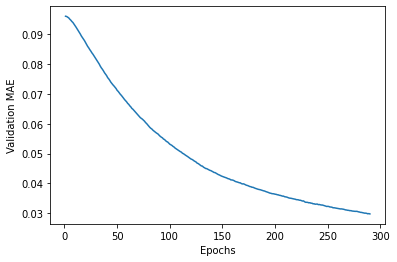

In [11]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [12]:
# Tune the model hyper paramters and retrain
model = build_model()

# Train on the entire dataset, 
model.fit(train_data,train_labels,epochs = 20,batch_size = 16,verbose = 1)

# Evaluate performace
test_mse_score,test_mae_score = model.evaluate(test_data,test_labels)

Epoch 1/20
94/94 [==============================] - 1s 3ms/step - loss: 0.0338 - mae: 0.1328
Epoch 2/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0242 - mae: 0.1137
Epoch 3/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0225 - mae: 0.1060
Epoch 4/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0207 - mae: 0.1015
Epoch 5/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0203 - mae: 0.0995
Epoch 6/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0192 - mae: 0.0978
Epoch 7/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0198 - mae: 0.0985
Epoch 8/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0189 - mae: 0.0955
Epoch 9/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0187 - mae: 0.0943
Epoch 10/20
94/94 [==============================] - 0s 3ms/step - loss: 0.0179 - mae: 0.0920
Epoch 11/20
94/94 [==============================] - 0s 3ms/step - lo

In [13]:
# Display the testing score
test_mae_score

0.09737828373908997

In [14]:
# Save
model.save('Programming Task4.hdf5')